# Mall Customers Clustering (K-Means, PCA, UMAP, HDBSCAN) 

This example uses an enhanced version of the mall customers dataset from Week 5 

Preprocess data, a bit of feature engineering, PCA, clustering and then plotting

## Imports

In [1]:
#take care of necessary installs
#!pip install kneed
#!pip install hdbscan
# !git clone https://github.com/CNUClasses/utils

In [2]:
#want to filter the seaborn warnings
import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime

from sklearn.cluster import DBSCAN
from sklearn import metrics
import sklearn.datasets as data
from sklearn.preprocessing import StandardScaler
    
import utils as ut


## Constants and Functions
Migrate these to a separate package when done so they can be used with scripts

In [4]:
RSEED=7

#lets compare each feature to all other features
def show_pairplot(df, hue):
    '''
    Shows a pairplot comparing all the features in a dataframe
    '''
    #this works on a small dataset, will be prohibitivly slow on a larger one
    To_Plot = [ col for col in df.columns]
    print("Relative Plot Of Some Selected Features: A Data Subset")
    plt.figure();
    # sns.pairplot(data=df[To_Plot], hue=hue, palette=ut.colors1)
    sns.pairplot(data=df[To_Plot], hue=hue,palette = "Paired");
    plt.show();

## Download the dataset 

In [5]:
# Download once (won't re-download if file exists)
import os, subprocess, shutil, urllib.request
DATA_URL = "https://raw.githubusercontent.com/CNUClasses/DATA301_CODE/master/week_6/Mall_CustomersNew.csv"
DATA_PATH = "Mall_CustomersNew.csv"

if os.path.exists(DATA_PATH):
    print(f"{DATA_PATH} already exists — skipping download.")
else:
    urllib.request.urlretrieve(DATA_URL, DATA_PATH)

Mall_CustomersNew.csv already exists — skipping download.


## Load Data

In [6]:
#load
df= pd.read_csv(DATA_PATH)
df

CustomerID  Gender  Annual Income (k$)    Birthday  spending_alcohol  \
0             1    Male                15.0  2004-04-22         11.623344   
1             2    Male                15.0  2002-09-05         26.986170   
2             3  Female                16.0  2003-10-28          1.087533   
3             4  Female                16.0  2000-09-02         26.988725   
4             5  Female                17.0  1992-11-10         12.693410   
..          ...     ...                 ...         ...               ...   
200         200    Male               137.0  1993-07-15         42.905180   
201         200    Male               137.0  1993-07-15         42.905180   
202         200    Male               137.0  1993-07-15         42.905180   
203         200    Male               137.0  1993-07-15         42.905180   
204         200    Male               137.0  1993-07-15         42.905180   

     spending_food  spending_sale  Active  
0         8.185354      19.191302    True  
1        27.769286      26.244544    True  
2         1.697070       3.215396    True  
3        17.576664      32.434611    True  
4        12.820811      14.485779    True  
..             ...            ...     ...  
200      29.614241      10.480579    True  
201      29.614241      10.480579    True  
202      29.614241      10.480579    True  
203      29.614241      10.480579    True  
204      29.614241      10.480579    True  

[205 rows x 8 columns]

### sns.pairplot to see if anything looks funny

Active has no variance (run df.nunique())

CustomerID is weirdly correlated with Annual Income.  It appears that they collected all customer data, sorted by income, and then assigned a customer ID to the sorted data

# Clean Data

In [8]:
from utils.transforms import *

# Dimensionality reduction
Lets try a couple of different ways 

## PCA 

A linear dimensionality reduction algorithm, works well for data distributions that are linear

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=.95)
features_pca=pd.DataFrame(pca.fit_transform(df))
print(f'Orig #features={df.shape[1]}, number features containing 95% of variance={features_pca.shape[1]}')

features_pca
pca.explained_variance_ratio_

Orig #features=6, number features containing 95% of variance=5


array([0.31361281, 0.191005  , 0.1642427 , 0.14376152, 0.14096045])

## UMAP

A non-linear dimensionality reduction algorithm, works well for data distributions that are NOT linear. For instance moon shaped. 

In [28]:
# UMAP dimensionality reduction
from umap import UMAP

# Configure UMAP hyperparameters
umap = UMAP(n_neighbors=5, #The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
            min_dist=0.3, # default 0.1, The effective minimum distance between embedded points.
            n_components=5, #The dimension of the space to embed into.  We could make this smaller and plot it
            metric='euclidean',
           random_state=RSEED)

features_umap=pd.DataFrame(umap.fit_transform(df))

/home/keith/anaconda3/envs/data301/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


## Lets plot these reduced dimensionality feature sets and see if we can visually 'see' any clusters

Tell UMAP to generate 2 components
and use the first 2 components of PCA

/home/keith/anaconda3/envs/data301/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


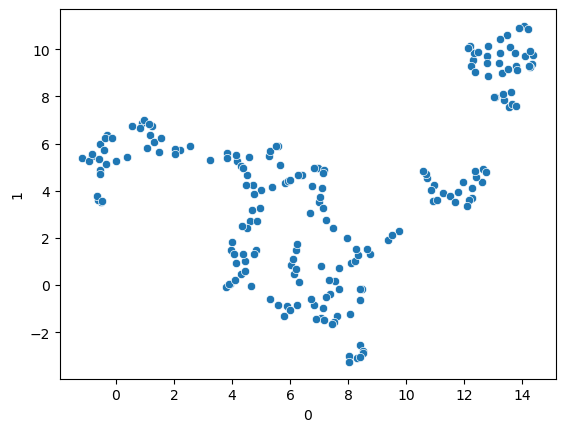

In [32]:
# Want to plot your data and see if there are any clusters?
umap2 = UMAP(n_neighbors=5, #The size of local neighborhood (in terms of number of neighboring sample points) used for manifold approximation.
            min_dist=0.3, # default 0.1, The effective minimum distance between embedded points.
            n_components=2, #The dimension of the space to embed into.  We could make this smaller and plot it
            metric='euclidean',
           random_state=RSEED)

features_umap2=pd.DataFrame(umap2.fit_transform(df))
sns.scatterplot(data=features_umap2,x=0,y=1);
# plt.clr()
plt.show()

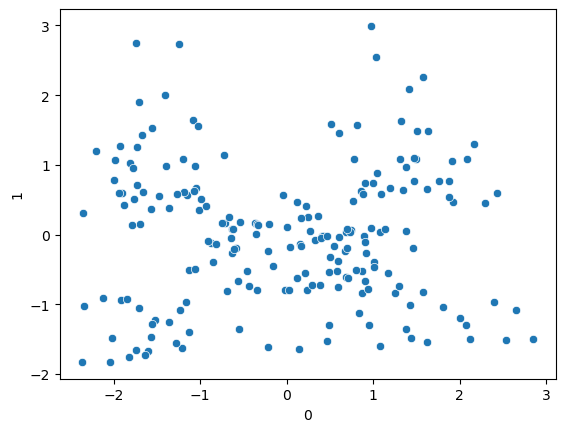

In [33]:
#can do the same for PCA but according to the explained_varience_ratio
#but the first 2 components only capture 50% of the data varience
#and it looks pretty ugly
sns.scatterplot(data=features_pca.iloc[:,[0,1]],x=0,y=1)
plt.show()

# KMEANS

In [34]:
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import KMeans

def runkmeansandsilhouette(features, cluster_sizes=[3,4,5,6,7,8,9,10,11,12,13,14,15]):
    '''
    runs kmeans on the features and returns the best cluster labels
    cluster_sizes : list of cluster sizes to try
    features: which features to run kmeans on'''
    bestcluster=None
    for cluster_size in cluster_sizes:   
        kmeans = KMeans(n_clusters=cluster_size, init='k-means++', random_state=RSEED)
        kmeans=kmeans.fit(features) 
        sc=silhouette_score(features, list(kmeans.labels_))
        if bestcluster is None or sc > bestcluster[1]:
            bestcluster=(cluster_size,sc,kmeans.labels_)
        print(f"for {cluster_size} clusters, silhouette_score={silhouette_score(features, list(kmeans.labels_))}") 

    print(f'Best cluster size={bestcluster[0]}')
    return bestcluster[2]

In [35]:
cluster_labels_pca=runkmeansandsilhouette(features_pca)
cluster_labels_umap=runkmeansandsilhouette(features_umap)

for 3 clusters, silhouette_score=0.22912381822960767
for 4 clusters, silhouette_score=0.2336627695777101
for 5 clusters, silhouette_score=0.23100644794280534
for 6 clusters, silhouette_score=0.22403331716290664
for 7 clusters, silhouette_score=0.21870371965061752
for 8 clusters, silhouette_score=0.21470730394979318
for 9 clusters, silhouette_score=0.21938275056491657
for 10 clusters, silhouette_score=0.2139191340112902
for 11 clusters, silhouette_score=0.21786411366756073
for 12 clusters, silhouette_score=0.2188521645016167
for 13 clusters, silhouette_score=0.22567996882372615
for 14 clusters, silhouette_score=0.22058068861505614
for 15 clusters, silhouette_score=0.227338583808354
Best cluster size=4
for 3 clusters, silhouette_score=0.48575255274772644
for 4 clusters, silhouette_score=0.42469578981399536
for 5 clusters, silhouette_score=0.4792116582393646
for 6 clusters, silhouette_score=0.4851335883140564
for 7 clusters, silhouette_score=0.45697838068008423
for 8 clusters, silhouette_

In [209]:
#maybe 6 is too many clusters, lets see if we can glean any insights using fewer clusters (try 4)
cluster_labels_pca=runkmeansandsilhouette(features_pca, cluster_sizes=[4])
cluster_labels_umap=runkmeansandsilhouette(features_umap, cluster_sizes=[4])

for 4 clusters, silhouette_score=0.2336627695777101
Best cluster size=4
for 4 clusters, silhouette_score=0.42469578981399536
Best cluster size=4


##  Plot both kmeans clusters derived from umap and from pca

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

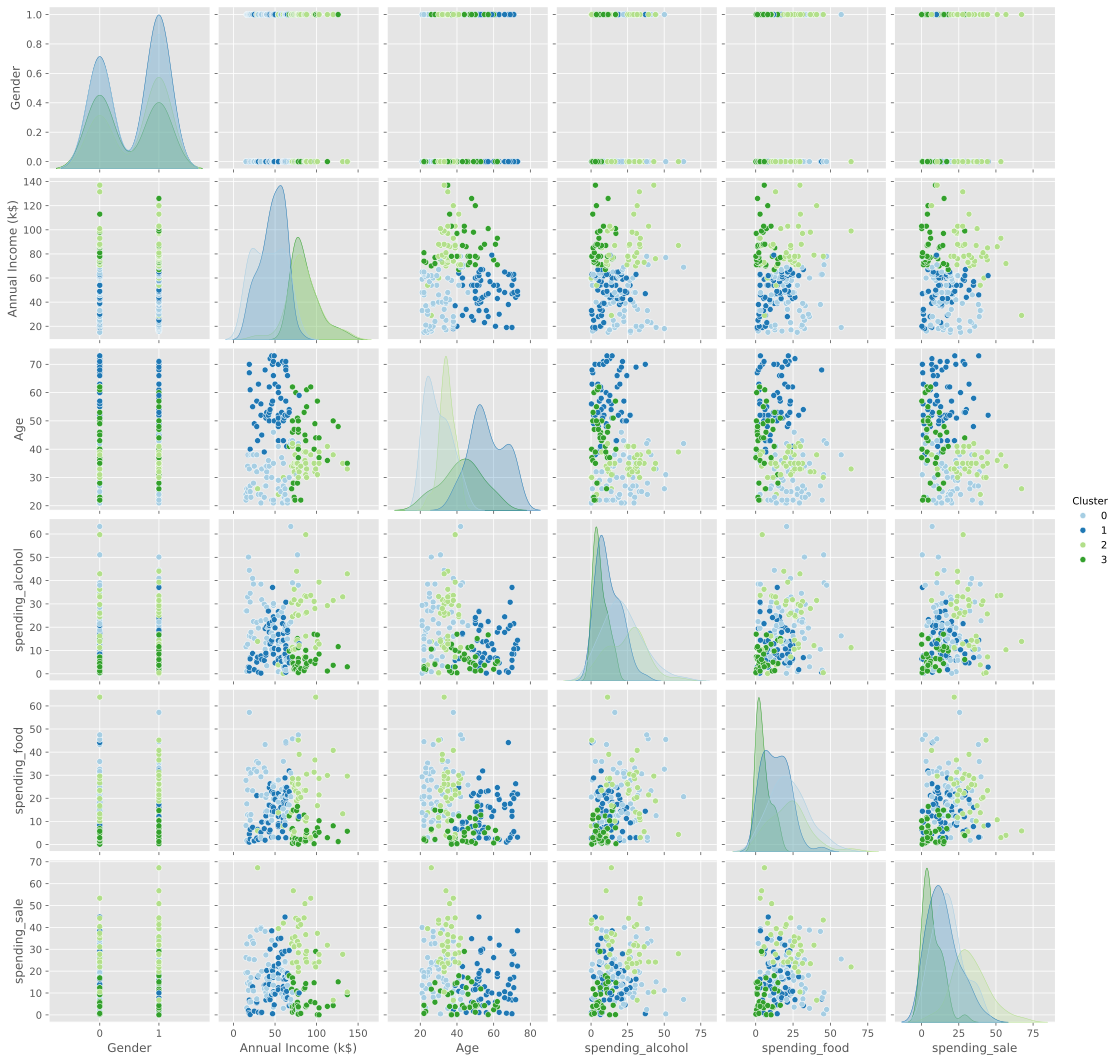

In [210]:
#first PCA
#lets plot the clusters
#only show non outliers
dforig['Cluster']=cluster_labels_pca
show_pairplot(dforig,hue='Cluster');

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

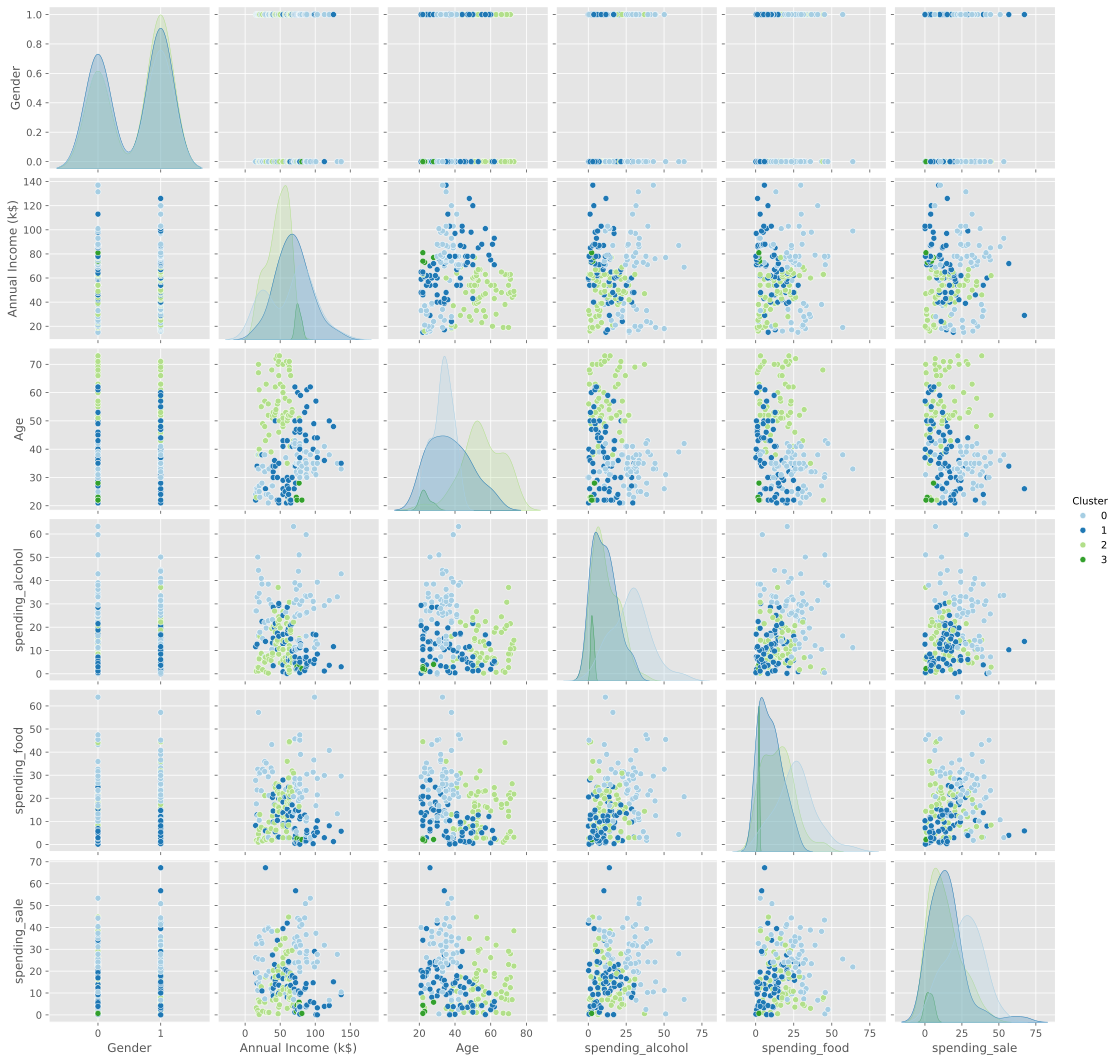

In [211]:
#then UMAP
#lets plot the clusters
#only show non outliers
dforig['Cluster']=cluster_labels_umap
show_pairplot(dforig,hue='Cluster');

Relative Plot Of Some Selected Features: A Data Subset


<Figure size 640x480 with 0 Axes>

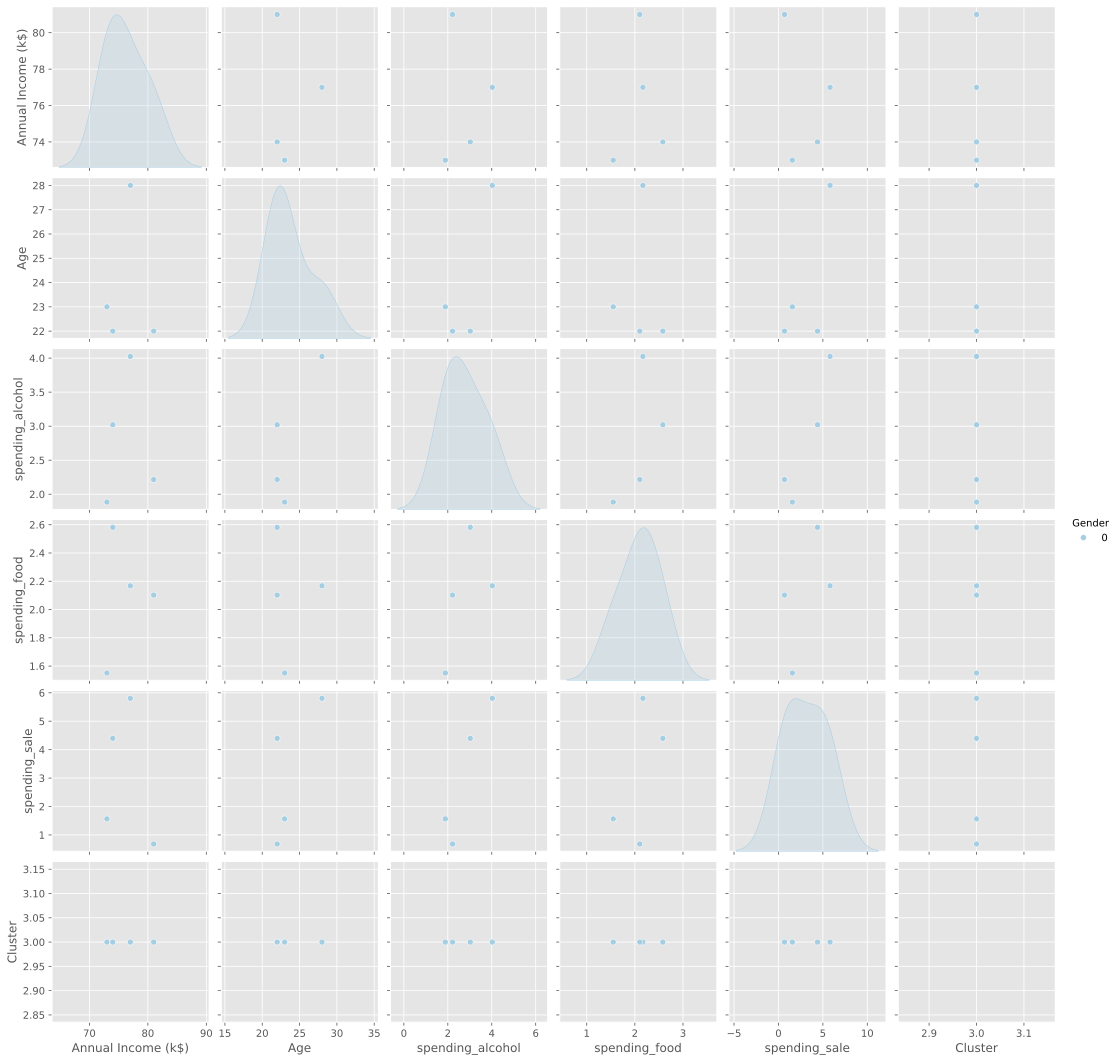

In [213]:
dfslce=dforig[dforig.Cluster==3]
show_pairplot(dfslce,hue='Gender');

## Its hard to tell what the clusters mean. Lets try groupby

In [214]:
#PCA
#lets see the means of each cluster
dforig['Cluster']=cluster_labels_pca
dforig.groupby('Cluster').mean().sort_values(by='Age')

Gender  Annual Income (k$)        Age  spending_alcohol  \
Cluster                                                              
0        0.550000           42.483333  29.800000         21.712968   
2        0.631579           84.960526  34.578947         24.209575   
3        0.473684           86.684211  42.921053          6.414269   
1        0.578125           47.593750  56.828125         12.067835   

         spending_food  spending_sale  
Cluster                                
0            22.311749      18.008616  
2            22.505053      32.916951  
3             5.135406       7.213483  
1            13.582110      14.646930

In [216]:
#UMAP
#lets see the means of each cluster
dforig['Cluster']=cluster_labels_umap
dforig.groupby('Cluster').mean().sort_values(by='Age')

Gender  Annual Income (k$)        Age  spending_alcohol  \
Cluster                                                              
3        0.000000           76.250000  23.750000          2.786788   
0        0.550000           65.058333  33.183333         28.184241   
1        0.550725           68.768116  37.449275         10.918443   
2        0.611940           47.223881  55.223881         11.690320   

         spending_food  spending_sale  
Cluster                                
3             2.100448       3.112764  
0            26.205135      26.460624  
1             9.798801      14.949423  
2            14.947318      13.601168

## Its hard to tell what the clusters mean. Lets try groupby